# Interconnect: Predicción de Cancelación de Clientes en una Compañía de Telecomunicaciones


Este proyecto se enfoca en desarrollar un modelo de clasificación binaria para predecir la tasa de cancelación de clientes (churn) en una empresa de telecomunicaciones. El objetivo es construir un modelo de aprendizaje supervisado que, utilizando datos históricos de los usuarios, pueda identificar aquellos que tienen una alta probabilidad de abandonar el servicio. Con esta información, la compañía podrá implementar estrategias de retención personalizadas, como ofertas promocionales y planes especiales, con el fin de reducir la tasa de cancelación y mejorar la fidelización de clientes.






### Tabla de contenido:

1. Inicialización
2. Cargar datos 
3. Preprocesamiento de datos
- 3.1.1. Información sobre contratos
- 3.1.2. Información personal
- 3.1.3. Información sobre telefonía
- 3.1.4. Información sobre servicios de internet
4. Funciones
5. Exploración de datos (EDA)
- 5.1. Concatenación de  toda la información
- 5.2. Desequilibrio de clases
- 5.3. Fechas
   -  5.3.1. Fechas de registro de contratos
   -  5.3.2. Fechas de cancelación de contratos
- 5.4. Tarifas
   - 5.4.1. Montos mensuales
      - 5.4.1.1 Promedio de montos mensuales por año
      - 5.4.1.2 Promedio de montos mensuales por tipo de contrato
   - 5.4.2. Montos totales
      - 5.4.2.1 Promedio de montos totales por año
      - 5.4.2.1 Promedio de montos totales por tipo de contrato
- 5.5. Cancelación de contratos
   - 5.5.1. Tasa de cancelación según tipo de contrato
   - 5.5.2. Cancelación según tipo de internet
   - 5.5.3. Cancelación según otros servicios derivados de internet
   - 5.5.4. Cancelación según género
   - 5.5.5. Cancelación según información personal
      - 5.5.5.1. Visualización de cancelación según información personal
- 5.6. Conclusiones EDA
6. Entrenamiento de los modelos
- 6.1. Preparación de datos para el entrenamiento 
- 6.2. Modelos
   - 6.2.1. Bosque aleatorio
   - 6.2.2. Árbol de decisión
   - 6.2.3. Catboost
   - 6.2.4. LightGBM
- 6.3. Selección del modelo
- 6.4. Conclusiones del entrenamiento 
7. Informe final
   

### 1. Inicialización

In [1]:
# Importar librerias
import pandas as pd
import os, sys
sys.path.append(os.getcwd())
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# Modelos 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

### 2. Cargar datos

In [3]:
# Leer los sets de datos 
user_contract = pd.read_csv('files/datasets/final_provider/contract.csv')
user_personal_info = pd.read_csv('files/datasets/final_provider/personal.csv')
phone_ser = pd.read_csv('files/datasets/final_provider/phone.csv')
internet_ser = pd.read_csv('files/datasets/final_provider/internet.csv') 

### 3. Prepocesamiento de datos

#### 3.1.1. Información sobre contratos

In [4]:
# Visualizar
user_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
# Visualizar
user_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Hay dos columnas con tipos de datos inadecuados.

In [6]:
# Revisar valores ausentes y duplicados
print('Ausentes:', '\n', user_contract.isna().sum(), '\n')
print('Duplicados:', user_contract.duplicated().sum(), '\n')

Ausentes: 
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64 

Duplicados: 0 



Sin datos duplicados ni ausentes

In [7]:
# Convertir 'BeginDate' a formato fecha
# Convetir 'TotalCharges' a formato float

user_contract['BeginDate'] = pd.to_datetime(user_contract['BeginDate'], format='%Y-%m-%d')
user_contract['TotalCharges'] = pd.to_numeric(user_contract['TotalCharges'], errors='coerce')

In [8]:
# Revisar valores ausentes y duplicados
print('Ausentes:', '\n', user_contract.isna().sum(), '\n')
print('Duplicados:', user_contract.duplicated().sum())

Ausentes: 
 customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64 

Duplicados: 0


Luego de la conversion de los tipos de datos en dos columnas, surgieron algunos datos ausentes en la conlumna de cargos totales. Como son pocos, los eliminare.

In [9]:
# Eliminar valores ausentes 
user_contract = user_contract.dropna().reset_index(drop=True)

# Comprobar dataset preprocesado 
print(user_contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 439.6+ KB
None


Ya no hay duplicados ni ausentes y los tipos de datos son correctos

#### 3.1.2. Información personal

In [10]:
# Visualizar
user_personal_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
# Visualizar
user_personal_info.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Los tipos de datos son correctos

In [12]:
# Verificar datos nulos o duplicados
print('Duplicados:', '\n', user_personal_info.isna().sum(), '\n')
print('Ausentes:', user_personal_info.duplicated().sum())

Duplicados: 
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64 

Ausentes: 0


No hay datos duplicados ni ausentes.

#### 3.1.3. Información sobre telefonía

In [13]:
# Visualizar
phone_ser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [14]:
# Visualizar
phone_ser.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Tipos de datos correctos

In [15]:
# Ver duplicados y ausentes 
print('Ausentes:', '\n', phone_ser.isna().sum(), '\n')
print('Duplicados:', phone_ser.duplicated().sum())

Ausentes: 
 customerID       0
MultipleLines    0
dtype: int64 

Duplicados: 0


No hay duplicados ni ausentes

#### 3.1.4. Información sobre servicios de internet

In [16]:
# Visualizar 
internet_ser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [17]:
# Visualizar
internet_ser.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Tipos de datos correctos

In [18]:
# Ver duplicados y ausentes
print('Ausentes:', '\n', internet_ser.isna().sum(), '\n')
print('Duplicados:', internet_ser.duplicated().sum())

Ausentes: 
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64 

Duplicados: 0


No hay duplicados ni ausentes

### 4. Funciones

In [19]:
""" Funcion para agrupar por un servicio derivado de internet y contar las cancelaciones   """   

def group_service(full_data, column):
    # Agrupar y contar los valores de 'Churn'
    values = full_data.groupby(column)['Churn'].value_counts().reset_index(name='count')

    # Conservar solo la clase negativa
    data = values[values['Churn'] == 0].drop(['Churn'], axis=1).reset_index(drop=True)

    if len(data) < 2:
        raise ValueError("No hay suficientes datos para las clases 'yes' y 'no'.")

    # Asignar 'yes' y 'no' basados en la condición
    yes = data.iloc[0]
    no = data.iloc[1]

    # Construir el DataFrame resultante
    result_df = pd.DataFrame({'type': [column], 'yes': [yes['count']], 'no': [no['count']]})
    return result_df


In [20]:

""" Funcion para agrupar dos caracteristicas de info personal y contar contratos cancelados """

def group_two_features(full_data, column_1, column_2):
    # Agrupar y contar los valores de 'Churn'
    values = full_data.groupby([column_1, column_2])['Churn'].value_counts().unstack().fillna(0).reset_index()
    
    # Filtrar solo la clase negativa para ver contratos cancelados
    churn_zero = values[values[0] > 0].copy()
    
    # Crear una lista para almacenar los resultados
    results = []
    
    # Definir las combinaciones de condiciones
    conditions = [
        (1, 1),  # Ambos true
        (1, 0),  # column_1 true, column_2 false
        (0, 1),  # column_1 false, column_2 true
        (0, 0)   # Ambos false
    ]
    
    # Iterar sobre cada combinación de condiciones
    for cond_1, cond_2 in conditions:
        condition_label = f"{column_1}={cond_1}, {column_2}={cond_2}"
        
        # Filtrar los valores que cumplen la condición
        subset = churn_zero[(churn_zero[column_1] == cond_1) & (churn_zero[column_2] == cond_2)]
        
        # Verificar si hay datos suficientes para la condición
        if subset.empty:
            continue
        
        # Construir la fila del DataFrame resultante
        result = {
            'condition': condition_label,
            'count': subset[0].values[0]  # La cantidad de churn=0 en esta combinación
        }
        results.append(result)
    
    # Convertir los resultados a un DataFrame
    result_data = pd.DataFrame(results)
    
    result_data = result_data.sort_values(by='count', ascending=False)
    
    return result_data

In [21]:

""" Funcion para codificar caracteristicas categoricas  en conjunto de entrenamiento """
def encoder_train(train_data):
    encoder = OrdinalEncoder()
    data_encoded = pd.DataFrame(encoder.fit_transform(train_data), columns=train_data.columns)
    data_encoded = data_encoded.astype('int')
    return data_encoded
    
    
    
""" Funcion para codificar caracteristicas categoricas  en conjunto de prueba """
def encoder_test(train_data, test_data):
    encoder = OrdinalEncoder()
    encoder.fit(train_data)
    data_test_encoded = pd.DataFrame(encoder.transform(test_data), columns=test_data.columns)
    data_test_encoded = data_test_encoded.astype('int')
    return data_test_encoded

In [22]:
""" Funcion para escalar caracteristicas numericas en conjunto de entrenamiento """
def scaler_train(train_data):
    scaler = StandardScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
    return data_scaled


""" Funcion para escalar caracteristicas numericas en conjunto de prueba """
def scaler_test(train_data, test_data):
    scaler = StandardScaler()
    scaler.fit(train_data)
    data_test_scaled = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)
    return data_test_scaled


In [23]:
""" Funcion para evaluar los modelos con roc_auc y exactitud  """

def model_eval(model, train_target, train_features):
    
    # Hacer predicciones con el modelo
    predictions = model.predict(train_features)
    
    # Predecir la probailidad de clase
    class_proba = model.predict_proba(train_features)
    
    # Extraer solo las probabilidades de la clase positiva (clase 1)
    class_proba_positive = class_proba[:, 1]
    
    # Evaluar el modelo con roc_auc
    model_auc_roc_score = roc_auc_score(train_target, class_proba_positive)
    
    # Evaluar el modelo con accuracy
    model_accuracy = accuracy_score(train_target, predictions)
    
    return model_auc_roc_score, model_accuracy


### 5. Exploración de datos (EDA)

#### 5.1. Concatenación de  toda la información

In [24]:
# Concatenar los datsets de contratos y servicios de internet
merge_1 = user_contract.merge(internet_ser, on='customerID', how='left')

In [25]:
# Comprobar valores ausentes y duplicados
print('Ausentes:', '\n', merge_1.isna().sum(), '\n')
print('Duplicados:', merge_1.duplicated().sum())

Ausentes: 
 customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
dtype: int64 

Duplicados: 0


Al realizar la concatenación, han surgido datos ausentes respecto a los servicios derivados de internet. 
Voy a suponer inicialmente que los valores ausentes corresponden a clientes que no pagan por tales servicios y por lo tanto, rellenare los faltantes con la palabra 'No', es decir; no tienen servicio de internet. 

In [26]:
# Rellenar ausentes con 'No'
merge_1 = merge_1.fillna('No')

# Comprobar datos ausentes 
merge_1.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [27]:
# Concatenar merge_1 con la informacion personal
merge_2 = merge_1.merge(user_personal_info, on='customerID', how='left')

In [28]:
# Comprobar datos ausentes y duplicados
print('Ausentes:', '\n', merge_2.isna().sum(), '\n')
print('Duplicados:', merge_2.duplicated().sum())

Ausentes: 
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
dtype: int64 

Duplicados: 0


In [29]:
# Concatenar merge_2 con la informacion de telefonia
full_data = merge_2.merge(phone_ser,  on='customerID', how='left')

In [30]:
# Comprobar valores ausentes y duplicados
print('Ausentes:', '\n', full_data.isna().sum(), '\n')
print('Duplicados:', full_data.duplicated().sum())

Ausentes: 
 customerID            0
BeginDate             0
EndDate               0
Type                  0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
MultipleLines       680
dtype: int64 

Duplicados: 0


Al realizar la concatenación, han surgido datos ausentes respecto a la información de lineas multiples. 
Voy a suponer inicialmente que los valores ausentes corresponden a clientes que no tienen este servicio de telefonía y por lo tanto, rellenare los faltantes con la palabra 'No', es decir; no tienen multiples lineas. 

In [31]:
# Rellenar ausentes con 'No'
full_data = full_data.fillna('No')

# Comprobar valores ausentes 
full_data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64

In [32]:
# Visualizar el nuevo dataset completo
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   InternetService   7032 non-null   object        
 9   OnlineSecurity    7032 non-null   object        
 10  OnlineBackup      7032 non-null   object        
 11  DeviceProtection  7032 non-null   object        
 12  TechSupport       7032 non-null   object        
 13  StreamingTV       7032 non-null   object        
 14  StreamingMovies   7032 n

In [33]:
# Visualizar el nuevo dataset completo
full_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


Con toda la información sobre los clientes reunida en un solo conjunto de datos, crearé un nueva columna llamada 'Churn' para ver la cancelacion de contratos, donde '1' será para contratos vigentes y '0' para contratos terminados.

In [34]:
# Crear una variable Churn 
full_data['Churn'] = full_data['EndDate']

# Convertir los 'No' en 'EndDate' a 1 y las fechas a 0 
full_data['Churn'] = full_data['Churn'].replace('No', '1').apply(lambda x: 1 if x == '1' else 0)

In [35]:
# Visualizar el df completo con la nueva variable 'Churn'
full_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,Female,0,Yes,No,No,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,No,1
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,0


#### 5.2. Desequilibrio de clases

In [36]:
# Evaluar el desequilibrio de clases en 'Churn'
full_data['Churn'].value_counts()

Churn
1    5163
0    1869
Name: count, dtype: int64

Se observa un fuerte desequilibrio entre las clases positiva y negativa.

#### 5.3. Fechas 
#### 5.3.1. Fechas de registro de contratos 

In [37]:
# Evaluar las primera y ultima fecha registradas 
print('Primera fecha registrada:', full_data['BeginDate'].sort_values().min())
print('Ultima fecha registrada:', full_data['BeginDate'].sort_values().max())


Primera fecha registrada: 2013-10-01 00:00:00
Ultima fecha registrada: 2020-01-01 00:00:00


Disponemos de información de contratos registrados desde el primero de octubre del año 2013 hasta el primero de enero del 2020.

#### 5.3.2. Fechas de cancelación de contratos

In [38]:
# Filtrar el df por contratos cancelados
churn_contracts = full_data[full_data['Churn']==0]

# Evaluar las fechas de las cancelaciones 
print('Primera fecha de cancelación:', churn_contracts['EndDate'].min())
print('Ultima fecha de cancelación registrada:', churn_contracts['EndDate'].max())

Primera fecha de cancelación: 2019-10-01 00:00:00
Ultima fecha de cancelación registrada: 2020-01-01 00:00:00


In [39]:
# Agrupar por fecha de incio y fecha de cancelacion
# Contar las cancelaciones
churn_dates = churn_contracts.groupby(['BeginDate', 'EndDate'])['Churn'].value_counts().sort_values(ascending=False)

churn_dates.head(20)

BeginDate   EndDate              Churn
2019-12-01  2020-01-01 00:00:00  0        105
2019-11-01  2019-12-01 00:00:00  0         99
2019-10-01  2019-11-01 00:00:00  0         93
2019-09-01  2019-10-01 00:00:00  0         83
            2019-11-01 00:00:00  0         33
2019-11-01  2020-01-01 00:00:00  0         32
2019-09-01  2019-12-01 00:00:00  0         31
2019-10-01  2019-12-01 00:00:00  0         29
2019-08-01  2019-10-01 00:00:00  0         29
2019-07-01  2019-11-01 00:00:00  0         25
            2019-12-01 00:00:00  0         22
2019-10-01  2020-01-01 00:00:00  0         22
2019-09-01  2020-01-01 00:00:00  0         21
2019-08-01  2019-11-01 00:00:00  0         21
2019-06-01  2019-11-01 00:00:00  0         20
2019-07-01  2019-10-01 00:00:00  0         20
2019-06-01  2019-10-01 00:00:00  0         19
2019-08-01  2019-12-01 00:00:00  0         18
2019-02-01  2019-11-01 00:00:00  0         17
2019-05-01  2019-11-01 00:00:00  0         17
Name: count, dtype: int64

Los contratos se han venido cancelando desde el primero de octubre del año 2019 hasta el primero de enero del 2020 (ultima fecha de registro de nuestro conjunto de datos). Significa que todas la cancelaciones se han hecho en los ultimos tres meses del conjunto de datos y analizando las fechas de incio, se puede ver que los clientes mas recientes son quienes más cancelan, con contratos que pueden durar hasta 1 solo mes. Quizás, en los ultimos meses hubo aumento de las tarifas en los servicios, pero lo analizaré más adelante al evaluar las tarifas.

#### 5.4. Tarifas 

In [40]:
# Extraer el año de registro los contratos y agregarlo al full_data
full_data['BeginYear'] = full_data['BeginDate'].dt.year

#### 5.4.1. Montos mensuales

#### 5.4.1.1 Promedio de montos mensuales por año

In [41]:
# Agrupar por año
# # Calcular el promedio de los montos mensuales
year_monthly_mean = full_data.groupby(['BeginYear'])['MonthlyCharges'].mean().reset_index(name='mean')

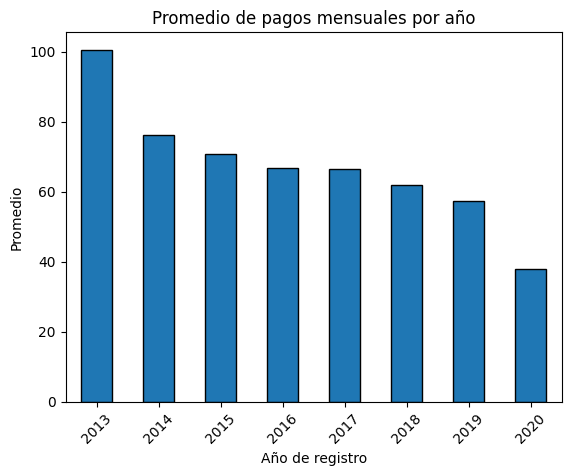

In [42]:
# Crear un grafico para visualizar el promedio de montos mensuales
ax_year_monthly_mean = year_monthly_mean['mean'].plot(kind='bar', edgecolor='black')

# Cambiar las etiquetas en eje x
ax_year_monthly_mean.set_xticklabels(year_monthly_mean['BeginYear'], rotation=45)

# Agregar título y etiquetas
plt.title('Promedio de pagos mensuales por año')
plt.xlabel('Año de registro')
plt.ylabel('Promedio')

plt.show()


Por lo que se observa, el promedio de montos mensuales disminuye progresivamente a través de los años.

#### 5.4.1.2 Promedio de montos mensuales por tipo de contrato

In [43]:
# Agrupar por tipo de contrato
# # Calcular el promedio de los montos mensuales 
type_monthly_mean = full_data.groupby(['Type'])['MonthlyCharges'].mean().reset_index(name='mean')

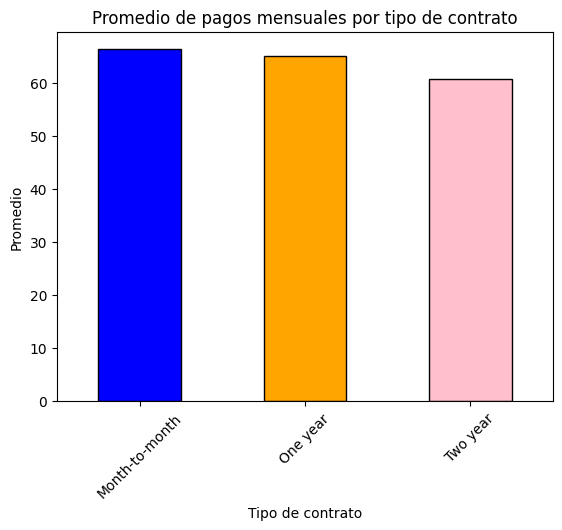

In [44]:
# Crear un grafico para visualizar el promedio de montos mensuales

colors = ['blue', 'orange', 'pink']

ax_type_monthly_mean = type_monthly_mean['mean'].plot(kind='bar', color= colors, edgecolor='black')

# Cambiar las etiquetas en eje x
ax_type_monthly_mean.set_xticklabels(type_monthly_mean['Type'], rotation=45)

# Agregar título y etiquetas
plt.title('Promedio de pagos mensuales por tipo de contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Promedio')

plt.show()


En cuanto al promedio de pagos mensuales por tipo de contrato, se observa que los clientes con contrato de dos años pagan en promedio un poco menos, mientras que los contratos mes a mes pagan un poco más.

#### 5.4.2. Montos totales

#### 5.4.2.1 Promedio de montos totales por año

In [45]:
# Agrupar por año y tipo de contrato
# # Calcular el promedio de los montos totales
year_total_mean = full_data.groupby(['BeginYear'])['TotalCharges'].mean().reset_index(name='mean')

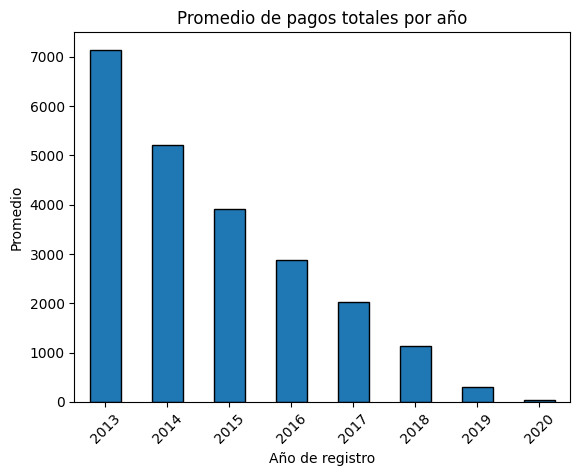

In [46]:
# Crear un grafico para visualizar el promedio de montos totales
ax_year_total_mean = year_total_mean['mean'].plot(kind='bar', edgecolor='black')

# Cambiar las etiquetas en eje x
ax_year_total_mean.set_xticklabels(year_total_mean['BeginYear'], rotation=45)

# Agregar título y etiquetas
plt.title('Promedio de pagos totales por año')
plt.xlabel('Año de registro')
plt.ylabel('Promedio')

plt.show()


El promedio de cargos totales disminuye de forma importante cada año.

#### 5.4.2.2 Promedio de montos totales por tipo de contrato

In [47]:
# Agrupar por tipo de contrato
# # Calcular el promedio de los montos totales
type_total_mean = full_data.groupby(['Type'])['TotalCharges'].mean().reset_index(name='mean')

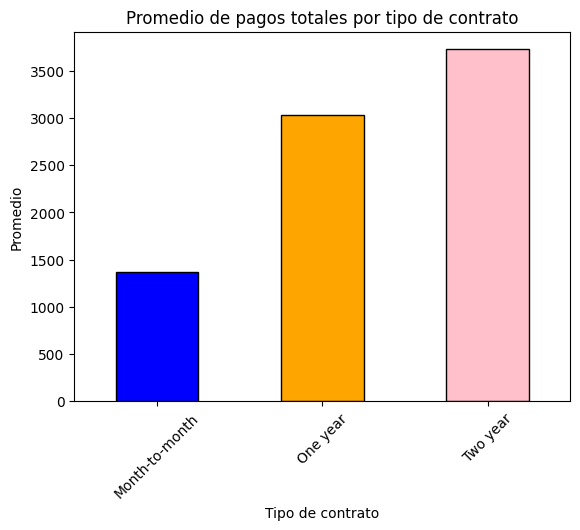

In [48]:
# Crear un grafico para visualizar el promedio de montos mensuales

colors = ['blue', 'orange', 'pink']

ax_type_total_mean = type_total_mean['mean'].plot(kind='bar', color= colors, edgecolor='black')

# Cambiar las etiquetas en eje x
ax_type_total_mean.set_xticklabels(type_total_mean['Type'], rotation=45)

# Agregar título y etiquetas
plt.title('Promedio de pagos totales por tipo de contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Promedio')

plt.show()


Al contrario que con los montos mensuales, donde en promedio los clientes con contrato mes a mes pagan mas que los contratos mas largos, el promedio de montos totales indica que los clientes con contratos de dos años pagan mucho más que los otros contratos. Quizas esto indica que los clientes que mas han cancelado contratos son los de contratos mas cortos y por eso reflejan un monto total mucho menor a pesar de pagar más mes a mes. 

#### 5.5. Cancelación de contratos

In [49]:
# Ver la cantidad total de contratos cancelados 
full_data[full_data['Churn'] == 0].count()


customerID          1869
BeginDate           1869
EndDate             1869
Type                1869
PaperlessBilling    1869
PaymentMethod       1869
MonthlyCharges      1869
TotalCharges        1869
InternetService     1869
OnlineSecurity      1869
OnlineBackup        1869
DeviceProtection    1869
TechSupport         1869
StreamingTV         1869
StreamingMovies     1869
gender              1869
SeniorCitizen       1869
Partner             1869
Dependents          1869
MultipleLines       1869
Churn               1869
BeginYear           1869
dtype: int64

Tenemos una totalidad de 1869 contratos cancelados.

#### 5.5.1. Tasa de cancelación según tipo de contrato

In [50]:
# Contar los contratos cancelados segun tipo de contrato
churn_per_type = full_data.groupby('Type')['Churn'].value_counts()

# Convertir el índice en columnas para acceder a los valores de 'Churn'
churn_per_type = churn_per_type.reset_index(name='Count')

# Filtrar los contratos vigentes 
in_ = churn_per_type[churn_per_type['Churn'] == 1].reset_index(drop=True)

# Eliminar la columna 'Churn'
in_ = in_.drop(['Churn'], axis=1).reset_index(drop=True)

# Renombrar la columnas en el df in_
in_.columns = ['Type', 'In']

# Filtrar los contratos cancelados
out_ = churn_per_type[churn_per_type['Churn'] == 0].reset_index(drop=True)

# Elmininar la columna 'Churn
out_ = out_.drop(['Churn'], axis=1).reset_index(drop=True)

# Renombrar las columnas en el df out_
out_.columns = ['Type', 'Out']

# Concatenar el conteo de contratos vigentes y cancelados  por tipo
type_contract_churn = in_.merge(out_, on='Type')

# Crear la conlumna 'Total' para la cantidad total de contratos por tipo 
type_contract_churn['Total'] = type_contract_churn['In'] + type_contract_churn['Out']

# Calcular el porcentaje de cancelacion segun el tipo de contrato 
type_contract_churn['Churn_rate'] = (type_contract_churn['Out'] / type_contract_churn['Total']) * 100

# Eliminar columna 'Total' 
type_contract_churn = type_contract_churn.drop(['Total'], axis=1)

type_contract_churn

,Type,In,Out,Churn_rate
0,Month-to-month,2220,1655,42.709677
1,One year,1306,166,11.277174
2,Two year,1637,48,2.848665


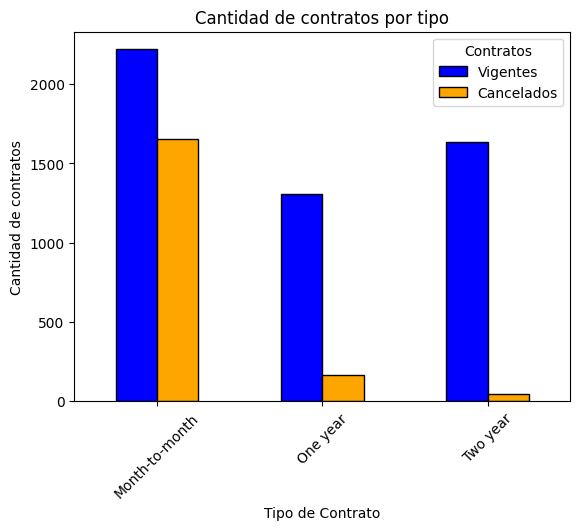

In [51]:
# Crear grafico de barras para la cantidad de cancelaciones por tipo de contrato
colors = ['blue', 'orange']

ax_type_contract_churn = type_contract_churn[['Type', 'In', 'Out']].plot(kind='bar', color=colors, edgecolor='black')

# Cambiar las etiquetas en el eje x
ax_type_contract_churn.set_xticklabels(type_contract_churn['Type'], rotation=45)

# Agregar título y etiquetas
plt.title('Cantidad de contratos por tipo')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Cantidad de contratos')
plt.legend(title='Contratos', labels=['Vigentes', 'Cancelados'])

plt.show()

En efecto, en la categoría de contratos mes a mes, se observa una cancelacion muy alta con respecto a los contratos que siguen vigentes. Luego siguen los contratos de un año y por ultimo, los de dos años; sin embargo, en estas dos últimas categorías, la cantidad de cancelaciones es muy baja en comparacion con contratos vigentes.

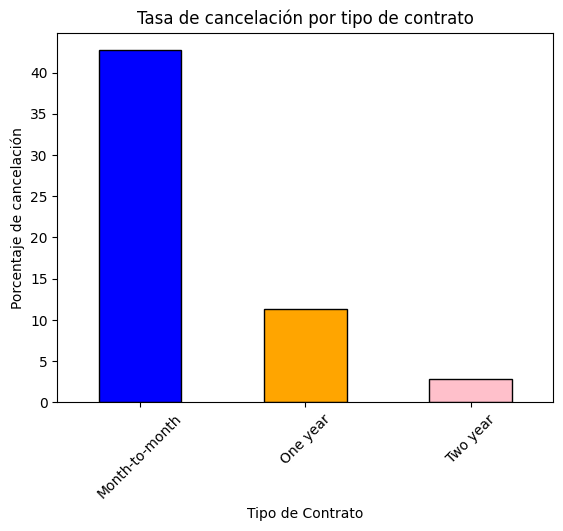

In [52]:
# # Graficar la tasa de cancelacion segun tipo de contrato
colors = ['blue', 'orange', 'pink']

ax_churn_rate = type_contract_churn['Churn_rate'].plot(kind='bar', color=colors, edgecolor='black')

# Cambiar las etiqueta en el eje x
ax_churn_rate.set_xticklabels(type_contract_churn['Type'], rotation=45)

# Agregar título y etiquetas
plt.title('Tasa de cancelación por tipo de contrato')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Porcentaje de cancelación')

plt.show()

La tasa de cancelación de cada tipo de contrato se ha calculado con respecto a la cantidad total de contratos existentes en cada una de las categorías.

Mediante la imagen se puede observar que los contratos mes a mes tienen una tasa de cancelación muy alta, de aproximadamente 43%, luego vemos una disminución abrupta en los contratos de un año, con alrededor de 11%, mientras que para los clientes que contratan por dos años, este porcentaje disminuye a casi 3%.

Esto confirma que lo que se vió en el gráfico para el promedio de pagos totales según el tipo de contrato, donde el promedio más alto correspondía a contratos de dos años y el más bajo a contratos mes a mes, a pesar de que los clientes de la categoría mes-a-mes pagan más, se debe a la tasa de abando. Esto se refleja proporcionalmente de manera inversa en ambos gráficos. 

#### 5.5.2. Cancelación según tipo de internet

In [53]:
# Contar contratos cancelados segun tipo de internet
internet_churn = full_data.groupby('InternetService')['Churn'].value_counts()	

# Convertir el indice en columna para acceder a 'Count'
internet_churn  = internet_churn.reset_index(name='Count')	

# Conservar solo la clase negativa (contratos cancelados)
internet_churn = internet_churn[internet_churn['Churn'] == 0].drop(['Churn'], axis=1).reset_index(drop=True)

# Organizar los valores de 'count'
internet_churn = internet_churn.sort_values(by='Count', ascending=False)

internet_churn

,InternetService,Count
1,Fiber optic,1297
0,DSL,459
2,No,113


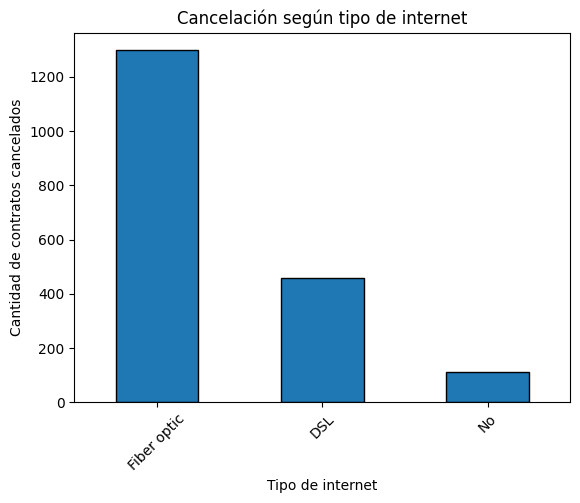

In [54]:
# Visualizar la canntidad de contratos cancelados segun tipo de internet
ax_internet_churn = internet_churn.plot(kind='bar', legend=False, edgecolor='black')

# Cambiar las etiquetas en el eje x
ax_internet_churn.set_xticklabels(internet_churn['InternetService'], rotation=45)

# Agregar título y etiquetas
plt.title('Cancelación según tipo de internet')
plt.xlabel('Tipo de internet')
plt.ylabel('Cantidad de contratos cancelados')
plt.show()

El internet de fibra óptica cuenta con la mayor cantidad de contratos cancelados, cuyo número se eleva a casi 1300. Por otro lado, el internet DSL tiene una cantidad mucho menor de cancelaciones, alrededor de 500. Y en cuanto a los clientes que no poseen servicio de internet, la cantidad de cancelaciones no llega a 150.

#### 5.5.3. Cancelación según otros servicios derivados de internet

In [55]:
# Crear un df para cada servicio de internet, filtrando unicamente la clase negativa,
# (contratos cancelados), usando una funcion

online_security_churn = group_service(full_data, 'OnlineSecurity')
online_backup_churn = group_service(full_data, 'OnlineBackup')
device_prot_churn = group_service(full_data, 'DeviceProtection')
tech_support_churn = group_service(full_data, 'TechSupport')
streaming_tv_churn = group_service(full_data, 'StreamingTV')
streaming_movies_churn = group_service(full_data, 'StreamingMovies')

In [56]:
# Lista de nombres de los servicios y los DataFrames correspondientes
services = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
dataframes = [online_security_churn, online_backup_churn, device_prot_churn, tech_support_churn, streaming_tv_churn, streaming_movies_churn]

# Crear el DataFrame usando una lista de comprensión
data_services = [
    {'type': service, 'yes': df['yes'].iloc[0], 'no': df['no'].iloc[0]} 
    for service, df in zip(services, dataframes)
]

# Convertir la lista de diccionarios en un DataFrame
inter_services_churn = pd.DataFrame(data_services)

# Ordenar el df por columna 'yes'
inter_services_churn = inter_services_churn.sort_values(by='yes', ascending=False)

inter_services_churn

,type,yes,no
0,online_security,1574,295
3,tech_support,1559,310
1,online_backup,1346,523
2,device_protection,1324,545
4,streaming_tv,1055,814
5,streaming_movies,1051,818


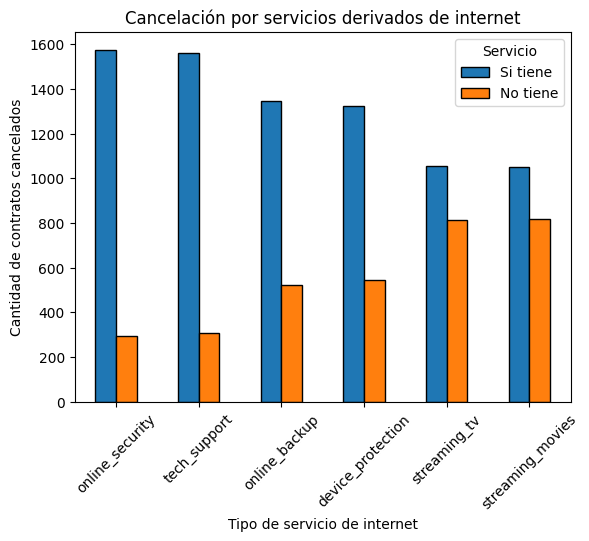

In [57]:
# Crear un grafico para visualizar cancelaciones en servicios derivados de internet 
ax_inter_services_churn = inter_services_churn.plot(kind='bar', edgecolor='black')

# Cambiar las etiquetas en el eje x
ax_inter_services_churn.set_xticklabels(inter_services_churn['type'], rotation=45)

# Agregar título y etiquetas
plt.title('Cancelación por servicios derivados de internet')
plt.xlabel('Tipo de servicio de internet')
plt.ylabel('Cantidad de contratos cancelados')
plt.legend(title='Servicio', labels=['Si tiene', 'No tiene'])
plt.show()

En cuanto a los servicios derivados de internet se puede notar que los clientes que si contratan dicho servicio son los que más cancelan su contrato, por consiguiente, los clientes que no contratan ese servicio tienen un menor índice de cancelación.

#### 5.5.4. Cancelación según género

In [58]:
# Contar los contratos agrupando por genero
gender_churn = full_data.groupby('gender')['Churn'].value_counts().reset_index(name='count')

# Conservar unicamente la clase negativa (contratos cancelados)
gender_churn = gender_churn[gender_churn['Churn'] == 0].drop(['Churn'], axis=1).reset_index(drop=True)

gender_churn

,gender,count
0,Female,939
1,Male,930


Al contar los contratos cancelados según el género, no se observa una diferencia significativa entre las cancelaciones de mujeres y hombres. Ambos presentan cantidades similares, por lo tanto, se podría inferir que el género no es un factor determinante a la hora de que un cliente cancela su contrato. 

#### 5.5.5. Cancelación según información personal

In [59]:
# filtrar la info personal de los clientes y la 'Churn'
personal_info_columns = full_data[['SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'Churn']]

# Conservar variables que no necesitan codificacion 
personal_info = personal_info_columns[['SeniorCitizen', 'Churn']]

# Codificar variables categoricas
personal_encoded = encoder_train(personal_info_columns[['Partner', 'Dependents', 'MultipleLines']])

# Unir las nuevas variables codificadas al resto del df que no necesito codificacion
personal_info[['Partner', 'Dependents', 'MultipleLines']] = personal_encoded 

/var/folders/82/grjgs_q959j1pwfb817_nsl80000gn/T/ipykernel_88445/1010544780.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personal_info[['Partner', 'Dependents', 'MultipleLines']] = personal_encoded
/var/folders/82/grjgs_q959j1pwfb817_nsl80000gn/T/ipykernel_88445/1010544780.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personal_info[['Partner', 'Dependents', 'MultipleLines']] = personal_encoded


In [60]:
# Agrupar 'SeniorCitizen' segun otras caracteristicas usando una funcion
senior_partner = group_two_features(personal_info, 'SeniorCitizen', 'Partner')
senior_dependents = group_two_features(personal_info, 'SeniorCitizen', 'Dependents')
senior_multiple_lines = group_two_features(personal_info, 'SeniorCitizen', 'MultipleLines')

#### 5.5.5.1. Visualización de cancelación según información personal

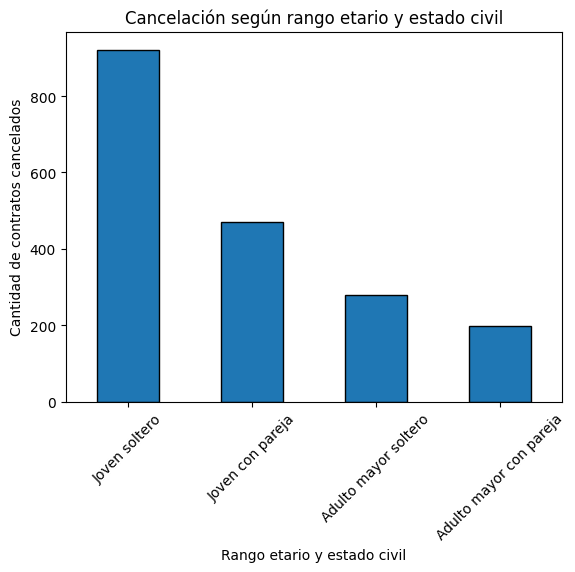

In [61]:
# visualizar cancelacion segun 'senior_citizen' y 'partner'
# colors = ['blue', 'orange']

ax_senior_partner = senior_partner.plot(kind='bar', edgecolor='black', legend=False)

# Cambiar el nombre de las etiquetas en el eje x
xlabels_names = [
    'Joven soltero',
    'Joven con pareja',
    'Adulto mayor soltero',
    'Adulto mayor con pareja'
    ]

ax_senior_partner.set_xticklabels(xlabels_names, rotation=45)

# Agregar título y etiquetas
plt.title('Cancelación según rango etario y estado civil')
plt.xlabel('Rango etario y estado civil')
plt.ylabel('Cantidad de contratos cancelados')

plt.show()



Se puede observar que la cantidad más alta de cancelaciones en los contratos la tienen las personas jovenes sin pareja. Esto es igual para mujeres y hombres.

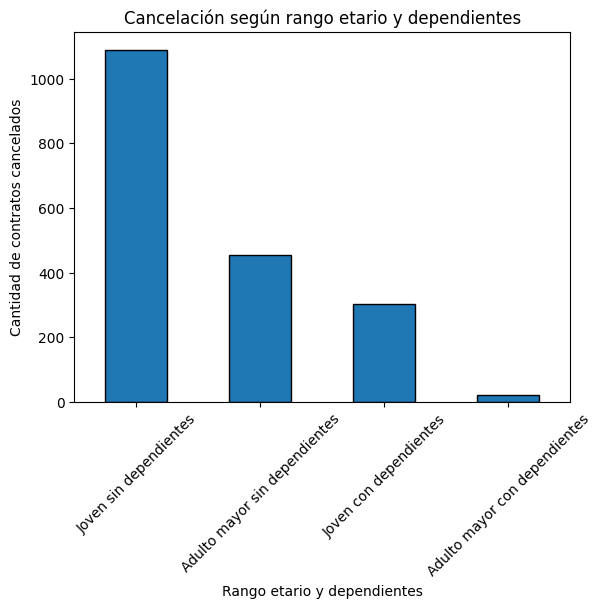

In [62]:
# visualizar cancelacion segun 'senior_citizen' y 'dependents''
# colors = ['blue', 'orange']

ax_senior_dependents = senior_dependents.plot(kind='bar', edgecolor='black', legend=False)

# Cambiar el nombre de las etiquetas en el eje x
xlabels_names = [
    'Joven sin dependientes',
    'Adulto mayor sin dependientes',
    'Joven con dependientes',
    'Adulto mayor con dependientes'
    ]

ax_senior_dependents.set_xticklabels(xlabels_names, rotation=45)

# Agregar título y etiquetas
plt.title('Cancelación según rango etario y dependientes')
plt.xlabel('Rango etario y dependientes')
plt.ylabel('Cantidad de contratos cancelados')

plt.show()


Se puede ver que hay una mayor cancelación entre las personas sin dependientes, y dentro de este grupo sin dependientes destancan las personas jovenes. 

Unido al gráfico anterior, se puede decir que quienes más cancelan contratos hasta ahora son las personas jóvenes, solteras y sin dependientes.

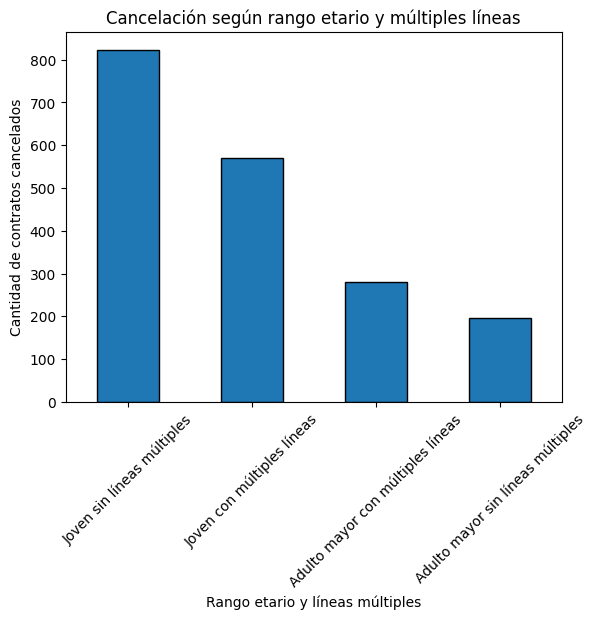

In [63]:
# visualizar cancelacion segun 'senior_citizen' y 'multiple_lines''
# colors = ['blue', 'orange']

ax_senior_lines = senior_multiple_lines.plot(kind='bar', edgecolor='black', legend=False)

# Cambiar el nombre de las etiquetas en el eje x
xlabels_names = [
    'Joven sin líneas múltiples',
    'Joven con múltiples líneas',
    'Adulto mayor con múltiples líneas',
    'Adulto mayor sin líneas múltiples'
    ]

ax_senior_lines.set_xticklabels(xlabels_names, rotation=45)

# Agregar título y etiquetas
plt.title('Cancelación según rango etario y múltiples líneas')
plt.xlabel('Rango etario y líneas múltiples')
plt.ylabel('Cantidad de contratos cancelados')

plt.show()


Las personas jóvenes sin servicio de líneas múltiples son quienes tienen la cantidad más alta de contratos cancelados.

#### 5.6. Conclusiones EDA

Mediante un análisis exploratorio detallado he encontrado varios aspectos interesantes en los referente a la tasa de cancelación de contratos dentro de la compañía. 

El conjunto que tengo a disposición recoje datos de clientes registrados desde el primero de octubre del 2013 hasta el primero de enero del 2020 (7 años) y las cancelaciones de algunos contratos se han venido realizando dentro de los últimos tres meses de dicho registro, es decir, desde el primero de octubre del año 2019 hasta el primero de enero del 2020 (última fecha registrada). 

Al ver las fechas de ingreso relacionadas a esas cancelaciones, se observan fechas recientes, del mismo año 2019. Significa que muchos de esos contratos duran apenas unos meses vigentes hasta que el cliente cancele. En varios casos durando incluso uno o dos meses dentro de la compañía solamente.

La empresa ofrece tres tipo de contratos: mes a mes, un año y dos años. El contrato mes a mes tiene la mayor tasa de cancelación, que corresponde al 43% de la cantidad total de contratos en esta categoría. Las otras dos tienen una tasa menos alarmante de abandono, 11% en el caso del contrato de un año y 3% en el de dos. 

Quizás podría influir un poco el hecho de que, en promedio, el contrato mes a mes paga mensualmete más que los otros dos tipos, pero ésta diferencia no es significativa en realidad.

Por otro lado, la compañía ofrece dos tipos de internet: fibra óptica y DSL. El de fibra óptica es el que tiene más cancelaciones, cerca de 1300, siendo que la cantidad total de contratos cancelados es 1869 en todo el registro. 

Además también se evaluó la cancelación en otros servicios derivados de internet, como seguriad online, streaming de películas, entre otros. El enfoque en este punto fue contrastar las cancelaciones entre clientes que han contratado el servicio adicional y los que no.
El resultado que encontré es que la cancelación es más alta entre clientes que sí contratan algunos de estos servicios adicionales. 

En lo referente al servicio de telefonía, la tasa más alta de abandono se encuentra entre los clientes que no contratan líneas múltiples.

Finalmente también se analizó la información personal que proporcionan los clientes, evaluando la cancelación mediante la combinación de variables, por ejemplo, su género, si tiene o no pareja o dependientes, entre otras características. 

En cuanto al género se puede decir que no influye directamente en la tasa de cancelación ya que tanto mujeres como hombres presentan aproximadamente la misma cantidad de contratos cancelados.

Finalmente, en base al análisis de toda la información personal puedo definir un pequeño perfil de los clientes más propensos a cancelar su contrato: se trata de personas jóvenes, solteras y sin dependientes, con contratos mes a mes. 


Una recomendación para reducir la tasa de abando entre clientes con este perfil, podría ser ofrecer un plan con una duración más larga que un mes y más corta que un año, algo en el medio, como un contrato a tres meses. De esta manera se podría generar arraigo dentro de la compañía y el cliente podría querer renovar su contrato por otro período igual de tres meses o posiblemente saltar al de un año. 

Tambíen se podrían ofrecer algunos servicios un poco más enfocado en este perfil de cliente propenso a abandono, tales como podcast y música.



### 6. Entrenamiento de los modelos

#### 6.1. Preparación de datos para el entrenamiento 

""" Segmentación de subconjuntos de datos """

In [64]:
# # Preparar los datos para entrenamiento
# Eliminar las columnas de fechas
data_to_split = full_data.drop(['EndDate', 'BeginDate'], axis=1)

# Dividir subconjuntos de entrenamiento, prueba y validación
data_train, data_test_1 = train_test_split(data_to_split, test_size=0.30, random_state=42)
data_test, data_valid = train_test_split(data_test_1, test_size=0.30, random_state=42)


print('Tamaño del conjunto de entrenamiento:', data_train.shape)
print('Tamaño del conjunto de prueba:', data_test.shape)
print('Tamaño del conjunto de valildación:', data_valid.shape)

Tamaño del conjunto de entrenamiento: (4922, 20)
Tamaño del conjunto de prueba: (1477, 20)
Tamaño del conjunto de valildación: (633, 20)


""" Codificación de variables categóricas y normalización de datos """

In [65]:
## <-- Preparacion conjunto de entrenamiento -->

# Filtrar columnas para codificar
train_to_encode = data_train[['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'Partner', 'Dependents', 'MultipleLines']]

# Filtrar columnas para escalar
train_to_scale = data_train[['MonthlyCharges', 'TotalCharges']]

# Filtrar el resto de las columnas 
train_other_columns = data_train[['customerID', 'Churn', 'SeniorCitizen']]

# ------------------------------------------------------------------------------

# Codificar conjunto de entrenamiento 
train_encoded = encoder_train(train_to_encode)

# Agregarle los IDs para realizar un merge luego
train_encoded['customerID'] = train_other_columns['customerID'].values

# Escalar conjunto de entrenamiento
train_scaled = scaler_train(train_to_scale)

# Agregarle los IDs para realizar un merge luego
train_scaled['customerID'] = train_other_columns['customerID'].values

# Unir todo en nuevo conjunto de entrenamiento escalado y codificado
merge_1 = train_other_columns.merge(train_encoded, on='customerID')

data_train_scaled = merge_1.merge(train_scaled, on='customerID')

In [66]:
## <-- Preparacion conjunto de prueba -->


# Filtrar columnas para codificar
test_to_encode = data_test[['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'Partner', 'Dependents', 'MultipleLines']]

# Filtrar columnas para escalar
test_to_scale = data_test[['MonthlyCharges', 'TotalCharges']]

# Filtrar el resto de columnas 
test_other_columns = data_test[['customerID', 'Churn', 'SeniorCitizen']]


# ------------------------------------------------------------------------------------------------

# Codificar conjunto de entrenamiento 
test_encoded = encoder_test(train_to_encode, test_to_encode)

# Agregarle los IDs para realizar un merge luego
test_encoded['customerID'] = test_other_columns['customerID'].values

# Escalar conjunto de entrenamiento
test_scaled = scaler_test(train_to_scale, test_to_scale)

# Agregarle los IDs para realizar un merge luego
test_scaled['customerID'] = test_other_columns['customerID'].values

# Unir todo en nuevo conjunto de entrenamiento escalado y codificado
merge_1 = test_other_columns.merge(test_encoded, on='customerID')

data_test_scaled = merge_1.merge(test_scaled, on='customerID')

In [67]:
## <-- Preparacion conjunto de validacion -->


# Filtrar columnas para codificar
valid_to_encode = data_valid[['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'Partner', 'Dependents', 'MultipleLines']]

# Filtrar columnas para escalar
valid_to_scale = data_valid[['MonthlyCharges', 'TotalCharges']]

# Filtrar resto de columnas 
valid_other_columns = data_valid[['customerID', 'Churn', 'SeniorCitizen']]

# ------------------------------------------------------------------------------------------------------------

# Codificar conjunto de entrenamiento 
valid_encoded = encoder_test(train_to_encode, valid_to_encode)

# Agregarle los IDs para realizar un merge luego
valid_encoded['customerID'] = valid_other_columns['customerID'].values

# Escalar conjunto de entrenamiento
valid_scaled = scaler_test(train_to_scale, valid_to_scale)

# Agregarle los IDs para realizar un merge luego
valid_scaled['customerID'] = valid_other_columns['customerID'].values

# Unir todo en nuevo conjunto de entrenamiento escalado y codificado
merge_1 = valid_other_columns.merge(valid_encoded, on='customerID')

data_valid_scaled = merge_1.merge(valid_scaled, on='customerID')

""" Cambio de índice a  'customerID' """

In [68]:
# Establecer 'customerID' como indice
data_train_scaled.set_index('customerID', inplace=True)

data_test_scaled.set_index('customerID', inplace=True)

data_valid_scaled.set_index('customerID', inplace=True)

""" Definición de características y objetivo """

In [69]:
# Definir las caracteristicas y el objetivo en conjunto de entrenamiento
train_features = data_train_scaled.drop(['Churn'], axis=1)
train_target = data_train_scaled['Churn']


# Definir caracteristicas y objetivo en conjunto de prueba
test_features = data_test_scaled.drop(['Churn'], axis=1)
test_target = data_test_scaled['Churn']


# Definir caracteristicas y objetivo en conjunto de validacion
valid_features = data_valid_scaled.drop(['Churn'], axis=1)
valid_target = data_valid_scaled['Churn']

#### 6.2. Modelos

#### 6.2.1. Bosque aleatorio 

In [70]:
# Crear un modelo de bosque aleatorio
rf_model = RandomForestClassifier(random_state=345,
                                      class_weight='balanced',
                                      criterion='entropy',
                                      max_depth=10,
                                      max_features='sqrt',
                                      min_samples_split=5,
                                      n_estimators=200
                                      )

In [71]:
# Entrenar el modelo de bosque aleatorio 
rf_model.fit(train_features, train_target)

# Evaluar el modelo en conjunto de entrenamiento
rf_roc_auc_train, rf_accuracy_train = model_eval(rf_model, train_target, train_features)

# Evaluar el modelo en conjunto de prueba 
rf_roc_auc_test, rf_accuracy_test = model_eval(rf_model, test_target, test_features)

In [72]:
# Mostrar outputs de evaluacion Roc_auc
print('Auc_roc en conjunto de entrenamiento:', rf_roc_auc_train)
print('Auc_roc en conjunto de prueba:', rf_roc_auc_test)

Auc_roc en conjunto de entrenamiento: 0.9434299420026435
Auc_roc en conjunto de prueba: 0.8331399899695806


In [73]:
# Mostrar outputs de evaluacion Exactitud
print('Exactitud en conjunto de entrenamiento', rf_accuracy_train)
print('Exactitud en conjunto de prueba', rf_accuracy_test)

Exactitud en conjunto de entrenamiento 0.8547338480292564
Exactitud en conjunto de prueba 0.7562626946513202


La diferencia del puntuaje de evaluación tanto en la curva AUC-ROC como en la exactitud, en los conjuntos de entrenamiento y prueba, parece indicar que el modelo de bosque aleatorio se sobreajusta en el entrenamiento. 

#### 6.2.2. Árbol de decisión

In [74]:
# Construir un modelo de arbol de decision
dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    criterion='gini',
    max_depth=5,
    max_features=6,
    min_samples_split=2,
    splitter='random'
    )

In [75]:
# Entrenar el modelo  
dt_model.fit(train_features, train_target)

# Evaluar el modelo en conjunto de entrenamiento
dt_roc_auc_train, dt_accuracy_train = model_eval(dt_model, train_target, train_features)

# Evaluar el modelo en conjunto de prueba 
dt_roc_auc_test, dt_accuracy_test = model_eval(dt_model, test_target, test_features)

In [76]:
# Mostrar outputs de evaluacion Roc_auc
print('Auc_roc en conjunto de entrenamiento:', dt_roc_auc_train)
print('Auc_roc en conjunto de prueba:', dt_roc_auc_test)

Auc_roc en conjunto de entrenamiento: 0.8171046084797653
Auc_roc en conjunto de prueba: 0.7889721632427315


In [77]:
# Mostrar outputs de evaluacion Exactitud
print('Exactitud en conjunto de entrenamiento', dt_accuracy_train)
print('Exactitud en conjunto de prueba', dt_accuracy_test)

Exactitud en conjunto de entrenamiento 0.744819179195449
Exactitud en conjunto de prueba 0.7183480027081923


Este modelo tiene menor precisión que el anterior pero no se muestra sobreajustado. 

#### 6.2.3. Catboost

In [78]:
# Construir un modelo catboost
cb_model = CatBoostClassifier(
    random_seed=42,
    iterations=150,          
    learning_rate=0.05,      
    loss_function='CrossEntropy',
    max_depth=6,           
    l2_leaf_reg=5,         
    early_stopping_rounds=20 
)

In [79]:
# Entrenar el modelo 
cb_model.fit(train_features, train_target,  cat_features=None)

# Evaluar el modelo en conjunto de entrenamiento
cb_roc_auc_train, cb_accuracy_train = model_eval(cb_model, train_target, train_features)

# Evaluar el modelo en conjunto de prueba 
cb_roc_auc_test, cb_accuracy_test = model_eval(cb_model, test_target, test_features)

0:	learn: 0.6742189	total: 55.5ms	remaining: 8.28s
1:	learn: 0.6565874	total: 57.7ms	remaining: 4.27s
2:	learn: 0.6407996	total: 60.9ms	remaining: 2.99s
3:	learn: 0.6257105	total: 62.9ms	remaining: 2.29s
4:	learn: 0.6115450	total: 66.3ms	remaining: 1.92s
5:	learn: 0.5981522	total: 68.2ms	remaining: 1.64s
6:	learn: 0.5863686	total: 70.1ms	remaining: 1.43s
7:	learn: 0.5758975	total: 73.2ms	remaining: 1.3s
8:	learn: 0.5657254	total: 76.6ms	remaining: 1.2s
9:	learn: 0.5567420	total: 79.8ms	remaining: 1.12s
10:	learn: 0.5482810	total: 81.8ms	remaining: 1.03s
11:	learn: 0.5404080	total: 82.8ms	remaining: 952ms
12:	learn: 0.5338019	total: 84.6ms	remaining: 892ms
13:	learn: 0.5272816	total: 86.9ms	remaining: 844ms
14:	learn: 0.5208198	total: 89.5ms	remaining: 806ms
15:	learn: 0.5141028	total: 91.9ms	remaining: 770ms
16:	learn: 0.5083943	total: 94.3ms	remaining: 738ms
17:	learn: 0.5028462	total: 97ms	remaining: 711ms
18:	learn: 0.4980674	total: 98.7ms	remaining: 680ms
19:	learn: 0.4938662	total

In [80]:
# Mostrar outputs de evaluacion Roc_auc
print('Auc_roc en conjunto de entrenamiento:', cb_roc_auc_train)
print('Auc_roc en conjunto de prueba:', cb_roc_auc_test)

Auc_roc en conjunto de entrenamiento: 0.8739254538500463
Auc_roc en conjunto de prueba: 0.8401144124002231


In [81]:
# Mostrar outputs de evaluacion Exactitud
print('Exactitud en conjunto de entrenamiento', cb_accuracy_train)
print('Exactitud en conjunto de prueba', cb_accuracy_test)

Exactitud en conjunto de entrenamiento 0.8201950426655831
Exactitud en conjunto de prueba 0.7968855788761002


Este modelo no demuestra  demasiado sobreajuste sin embargo, el puntaje AUC-ROC no es lo suficientemente alto.

#### 6.2.4. LightGBM

In [82]:
# Construir el modelo lightgbm
lgbm_model = LGBMClassifier(
    random_state=42,
    n_estimators=200,          
    learning_rate=0.01,        
    objective='binary',
    class_weight='balanced',
    max_depth=6,               
    reg_alpha=0.1,             
    reg_lambda=0.1,            
    subsample=0.8,             
    colsample_bytree=0.8,
)

In [83]:
# Entrenar el modelo
lgbm_model.fit(train_features, train_target)

# Evaluar el modelo en conjunto de entrenamiento
lgbm_roc_auc_train, lgbm_accuracy_train = model_eval(lgbm_model, train_target, train_features)

# Evaluar el modelo en conjunto de prueba 
lgbm_roc_auc_test, lgbm_accuracy_test = model_eval(lgbm_model, test_target, test_features)

In [84]:
# Mostrar outputs de evaluacion Roc_auc
print('Auc_roc en conjunto de entrenamiento:', lgbm_roc_auc_train)
print('Auc_roc en conjunto de prueba:', lgbm_roc_auc_test)

Auc_roc en conjunto de entrenamiento: 0.886827411747384
Auc_roc en conjunto de prueba: 0.8371943417185765


In [85]:
# Mostrar outputs de evaluacion Exactitud
print('Exactitud en conjunto de entrenamiento:', lgbm_accuracy_train)
print('Exactitud en conjunto de prueba:', lgbm_accuracy_test)

Exactitud en conjunto de entrenamiento: 0.7822023567655425
Exactitud en conjunto de prueba: 0.7251184834123223


Este modelo proporciona el puntaje AUC-ROC más alto sin presentar demasiado sobreajuste en el entrenamiento, por lo tanto, este será elegido para la tarea de clasificación.

#### 6.3. Selección del modelo

El modelo lightGBM resulta apropiado para la tarea de clasificación de nuestros datos, de modo que será el modelo seleccionado y a continuación, lo evaluaré en el conjunto de validación.

In [86]:
# Evaluar el modelo en conjunto de validación
lgbm_roc_auc_valid, lgbm_accuracy_valid = model_eval(lgbm_model, valid_target, valid_features)

In [87]:
# Mostrar outputs de evaluacion Roc_auc
print('Auc_roc en conjunto de entrenamiento:', lgbm_roc_auc_train)     
print('Auc_roc en conjunto de validación', lgbm_roc_auc_valid)

Auc_roc en conjunto de entrenamiento: 0.886827411747384
Auc_roc en conjunto de validación 0.8275294903754722


In [88]:
# Mostrar outputs de evaluacion Exactitud
print('Exactitud en conjunto de entrenamiento', lgbm_accuracy_train)
print('Exactitud en conjunto de validación', lgbm_accuracy_valid)

Exactitud en conjunto de entrenamiento 0.7822023567655425
Exactitud en conjunto de validación 0.7330173775671406


#### 6.4. Conclusiones del entrenamiento 

Para la tarea de clasificación que aborda este proyecto, se construyeron cuatro tipos de modelos de machine learning: bosque aleatorio, árbol de decisión, catboost y lightGBM. 

Todos los modelos fueron entrenados con datos normalizados o escalados, utilizando un subconjunto de entrenamiento. Por otro lado, cómo métrica de evaluación se utilizó pricipalmente la curva AUC-ROC y de manera complementaria la de exactitud, en un subconjunto de prueba.

El modelo seleccionado obtuvo un puntaje AUC-ROC de 0.88 y una exactitud de 0.73 en el conjunto de entrenamiento y no mostró demasiado sobreajuste. Se trata del lightGBM. 

Por último, evalué una vez más el modelo seleccionado en un subconjunto de validación pequeño, donde obtuve un puntaje de 0.82 para AUC-ROC y 0.73 en exactitud. Aunque la métrica disminuye cuando la comparamos con el puntaje de evaluación obtenido en el subconjunto de entrenamiento, esto puede deberse a las pequeñas variaciones de la desviación estandar en ambos conjuntos, sobretodo tomando en cuenta el tamaño pequeño de la muestra de validación y el tamaño grande de la muestra de entrenamiento.


### 7. Informe final

---
#### A. ¿Qué pasos del plan se realizaron y qué pasos se omitieron?

Se realizaron todos los pasos expuestos en el plan de trabajo, los cuales fueron:

##### 1. Preprocesamiento y Evaluación de Datos

Tenía a disposición cuatro conjuntos de datos donde se separaba la información de los clientes dependiendo del servicio ofrecido por la compañía. En cada uno revisé los tipos de datos, así como los valores ausentes o duplicados y modifiqué en los casos en que fue necesario. 

Al asegurarme de tener todos los datos debidamente procesados, realicé la unión de toda la información en un solo conjunto, lo que me permitió pasar a la exploración de todas las variables disponibles sin perder información importante.

Luego de tener toda la información reunida en un solo set, procedí a segmentar en subconjuntos de entrenamiento, validación y prueba que utilizaría más adelante con los modelos, y en cada uno de ellos hice un proceso de codificación para variables categóricas y escalado para variables numéricas, por separado. De este modo, me aseguré de que entrenaría los modelos con datos normalizados para evitar sobreajustes u otros inconvenientes. 

##### 2. Determinación del Tipo de Tarea de Machine Learning

Se determinó que la tarea correspondía a una clasificación binaria, ya que necesitabamos saber si un cliente abandonaría la compañía o no. Y establecer el tipo de tarea, me permitió decidir qué tipos de modelos construiría y entrenaría más adelante.

##### 3. Desarrollo y Entrenamiento de Modelos

Construí y entrené cuatro modelos, la mayoría de ellos basados en árboles: bosque aleatorio, árbol de decisión, lightGBM y catboost.

Cada uno de los modelos se evaluó usando un subconjunto de prueba, teniendo como métrica principal AUC-ROC y como secundaria, exactitud. 

##### 4. Selección del Mejor Modelo

Se eligió el modelo con el puntaje AUC-ROC más alto sin muestra de mucho sobreajuste en el entrenamiento.

##### 5. Prueba del Modelo Seleccionado

El modelo se evaluó en un subconjunto de validación más pequeño previamente separado solo para este propósito.


##### 6. Preparación del Informe de Resultado

Se añadieron conclusiones al final de la etapa de exploración de los datos y al final de la etapa de entrenamiento y selección del modelo. 
Por último se incluye el presente informe de resultados. 


---
#### B. ¿Qué dificultades encontraste y cómo lograste resolverlas?

Una de las dificultades más importantes que encontré fue al momento de normalizar mis datos, puesto que había empleado un función que me permitía escalar y codificar el conjunto de datos completo, realizando un solo paso de "fit_transform" en todo el set y luego segmenté en subconjuntos de entrenamiento, validación y prueba, lo que ocasionó un gran sobreajuste al entrenar los modelos. 

La solución para este problema fue tomar los datos originales y realizar la segmentación de los subconjuntos primero, antes de cualquier transformación. Luego, construí un nuevo escalador y codificador y los entrené con el set de entrenamiento.

Posteriormente escalé y codifiqué cada subconjunto por separado, realizando solamente un paso de "transform" para los subconjuntos de valildación y prueba. Así tuve datos adecuados para el entrenamiento de los modelos y logré reducir el sobreajuste.


--- 
#### C.  ¿Cuáles fueron algunos de los pasos clave para resolver la tarea?

Uno de los pasos claves fue reunir toda la información de los clientes y realizar la exploración en un solo conjunto de datos completo.

Otro paso fundamental fue la exploración de los datos misma, ya que de esta manera me relacioné muy bien con toda la información y logré entender en gran medida el comportamiento de los clientes y realizar un perfil de los usuarios más propensos a abandonar la compañía.

Por otro lado, también resultó clave la creación de distintas funciones para reducir código en las tareas más repetitivas, como la evaluación de los modelos por ejemplo. 


---
#### D. ¿Cuál es tu modelo final y qué nivel de calidad tiene?

El modelo elegido fue el lightGBM, que obtuvo un puntaje AUC-ROC de 0.88 y una exactitud de 0.73 en el conjunto de entrenamiento y no mostró demasiado sobreajuste. 

Yo diría que aunque no es un modelo perfecto, ya que las métricas bajaron un poco en el conjunto de validación final, su calidad es buena. 